In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import halfnorm

In [ ]:
def half_normal(d, scale):
    """Half-normal detection function."""
    return halfnorm.pdf(d, scale=scale) / halfnorm.pdf(0, scale=scale)

def compute_distances(xs, ys, grid_x, grid_y):
    """Compute minimum distance from each grid point to any recorder."""
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    distances = np.full(X.shape, np.inf)
    for x, y in zip(xs, ys):
        dist = np.sqrt((X - x)**2 + (Y - y)**2)
        distances = np.minimum(distances, dist)
    return distances

def calculate_probs(det_func, distances):
    """Apply detection function to distances."""
    return det_func(distances)

def detection_probabilities(probs):
    """Convert individual probabilities to combined detection probability."""
    # Using 1 - product(1 - p_i) for multiple independent detectors
    # But since we're using minimum distance, probs is already the max detection
    return probs

def mean_probability_in_mask(prob_map, mask):
    """Calculate mean probability within the masked region."""
    if not np.any(mask):
        return 0.0
    return np.mean(prob_map[mask])

def min_probability_in_mask(prob_map, mask):
    """Calculate minimum probability within the masked region."""
    if not np.any(mask):
        return 0.0
    return np.min(prob_map[mask])

In [ ]:
def semicircle_mask(grid_x, grid_y, radius, center=(0, 0)):
    """Generate a semicircle mask (upper half)."""
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = (dist_from_center <= radius) & (Y >= center[1])
    return mask

def circle_mask(grid_x, grid_y, radius, center=(0, 0)):
    """Generate a full circle mask."""
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    return dist_from_center <= radius

def rectangle_mask(grid_x, grid_y, xmin, xmax, ymin, ymax):
    """Generate a rectangular mask."""
    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    return (X >= xmin) & (X <= xmax) & (Y >= ymin) & (Y <= ymax)

def load_mask_from_image(image_path, grid_x, grid_y, threshold=128):
    """
    Load a mask from a PNG image.

    Parameters:
    -----------
    image_path : str
        Path to the PNG image (black and white)
    grid_x, grid_y : array-like
        Grid coordinates
    threshold : int
        Pixel values above this threshold are considered as mask region

    Returns:
    --------
    mask : np.ndarray
        Boolean mask matching the grid dimensions
    """
    img = Image.open(image_path).convert('L')  # Convert to grayscale

    # Get grid dimensions
    nx, ny = len(grid_x), len(grid_y)

    # Resize image to match grid
    img_resized = img.resize((nx, ny), Image.Resampling.LANCZOS)

    # Convert to numpy array and create boolean mask
    img_array = np.array(img_resized)
    mask = img_array > threshold

    return mask

def create_custom_shape_mask(grid_x, grid_y, vertices):
    """
    Create a mask from a polygon defined by vertices.

    Parameters:
    -----------
    grid_x, grid_y : array-like
        Grid coordinates
    vertices : list of tuples
        List of (x, y) coordinates defining the polygon

    Returns:
    --------
    mask : np.ndarray
        Boolean mask
    """
    from matplotlib.path import Path

    X, Y = np.meshgrid(grid_x, grid_y, indexing='ij')
    points = np.vstack([X.ravel(), Y.ravel()]).T

    path = Path(vertices)
    mask = path.contains_points(points).reshape(X.shape)

    return mask

In [ ]:
class Individual:
    def __init__(self, num_recorders, bounds):
        self.num_recorders = num_recorders
        self.bounds = bounds
        self.xs, self.ys = self.random_positions()
        self.fitness_value = None

    def random_positions(self):
        xmin, xmax, ymin, ymax = self.bounds
        xs = np.random.uniform(xmin, xmax, self.num_recorders)
        ys = np.random.uniform(ymin, ymax, self.num_recorders)
        return xs, ys

    def mutate(self, rate, std):
        xs_new, ys_new = self.xs.copy(), self.ys.copy()
        mask = np.random.rand(len(xs_new)) < rate
        xs_new[mask] += np.random.normal(0, std, np.sum(mask))
        ys_new[mask] += np.random.normal(0, std, np.sum(mask))
        xmin, xmax, ymin, ymax = self.bounds
        xs_new = np.clip(xs_new, xmin, xmax)
        ys_new = np.clip(ys_new, ymin, ymax)
        self.xs, self.ys = xs_new, ys_new

    @staticmethod
    def crossover(parent1, parent2):
        alpha = np.random.rand()
        xs = alpha * parent1.xs + (1 - alpha) * parent2.xs
        ys = alpha * parent1.ys + (1 - alpha) * parent2.ys
        child = Individual(parent1.num_recorders, parent1.bounds)
        child.xs, child.ys = xs, ys
        return child

In [ ]:
class Environment:
    def __init__(self, grid_x, grid_y, det_func, mask,
                 pop_size=30, generations=100, num_recorders=8, bounds=(-30, 30, -30, 30),
                 mutation_rate=0.2, mutation_std=1.5, metric='mean',
                 empty_penalty=True, close_penalty=True,
                 empty_penalty_fraction=0.3, close_penalty_fraction=0.2,
                 min_dist=3.0, stagnation_limit=10, restart_fraction=0.3):
        """
        Flexible GA environment that works with any mask shape.

        Parameters:
        -----------
        grid_x, grid_y : array-like
            Grid coordinates
        det_func : callable
            Detection function f(distance) -> probability
        mask : np.ndarray
            Boolean mask defining the region of interest
        """
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.det_func = det_func
        self.mask = mask  # Now we just store the mask directly!

        self.pop_size = pop_size
        self.generations = generations
        self.num_recorders = num_recorders
        self.bounds = bounds
        self.mutation_rate = mutation_rate
        self.mutation_std = mutation_std
        self.metric = metric

        self.empty_penalty = empty_penalty
        self.close_penalty = close_penalty
        self.empty_penalty_fraction = empty_penalty_fraction
        self.close_penalty_fraction = close_penalty_fraction
        self.min_dist = min_dist

        # Adaptive GA params
        self.stagnation_limit = stagnation_limit
        self.restart_fraction = restart_fraction

    def evaluate(self, individual):
        """Evaluate fitness of an individual."""
        distances = compute_distances(individual.xs, individual.ys, self.grid_x, self.grid_y)
        probs = calculate_probs(self.det_func, distances)
        prob_map = detection_probabilities(probs)

        # Calculate score based on metric
        if self.metric == "mean":
            score = mean_probability_in_mask(prob_map, self.mask)
        elif self.metric == "maxmin":
            score = min_probability_in_mask(prob_map, self.mask)
        else:
            score = mean_probability_in_mask(prob_map, self.mask)

        # Empty penalty: penalize low probability areas
        if self.empty_penalty:
            low_prob_area = np.mean(prob_map[self.mask] < 0.2) if np.any(self.mask) else 0
            score -= self.empty_penalty_fraction * low_prob_area

        # Close penalty: penalize recorders too close to each other
        if self.close_penalty:
            dists = np.sqrt((individual.xs[:, None] - individual.xs[None, :])**2 +
                            (individual.ys[:, None] - individual.ys[None, :])**2)
            np.fill_diagonal(dists, np.inf)
            too_close_fraction = np.mean(dists < self.min_dist)
            score -= self.close_penalty_fraction * too_close_fraction

        individual.fitness_value = score
        return score

    def select_parents(self, population):
        """Select top parents for reproduction."""
        population.sort(key=lambda ind: ind.fitness_value, reverse=True)
        return population[:5]

    def complex_mutate(self, ind):
        """Apply a mixture of mutation strategies."""
        ind.mutate(self.mutation_rate, self.mutation_std)

        # Occasional "swap" of positions
        if np.random.rand() < 0.2:
            i, j = np.random.choice(len(ind.xs), 2, replace=False)
            ind.xs[i], ind.xs[j] = ind.xs[j], ind.xs[i]
            ind.ys[i], ind.ys[j] = ind.ys[j], ind.ys[i]

        # Occasional "jitter all"
        if np.random.rand() < 0.1:
            ind.xs += np.random.normal(0, 0.3, len(ind.xs))
            ind.ys += np.random.normal(0, 0.3, len(ind.ys))
            xmin, xmax, ymin, ymax = self.bounds
            ind.xs = np.clip(ind.xs, xmin, xmax)
            ind.ys = np.clip(ind.ys, ymin, ymax)

    def run(self, verbose=True, k_top=3):
        """Run the genetic algorithm."""
        population = [Individual(self.num_recorders, self.bounds) for _ in range(self.pop_size)]
        best_scores, best_fitness = [], -np.inf
        stagnation_counter = 0

        for gen in range(self.generations):
            # Evaluate population
            for ind in population:
                self.evaluate(ind)
            population.sort(key=lambda i: i.fitness_value, reverse=True)
            best = population[0]

            mean_fit = np.mean([i.fitness_value for i in population])
            best_scores.append(best.fitness_value)

            # Check for improvement
            if best.fitness_value > best_fitness + 1e-5:
                best_fitness = best.fitness_value
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            if verbose:
                print(f"Gen {gen+1:02d} | Mean={mean_fit:.4f} | Best={best.fitness_value:.4f} | Stag={stagnation_counter}")

            # Stagnation handling
            if stagnation_counter >= self.stagnation_limit:
                stagnation_counter = 0
                n_replace = int(self.restart_fraction * self.pop_size)
                for i in range(-n_replace, 0):
                    population[i] = Individual(self.num_recorders, self.bounds)
                    self.evaluate(population[i])
                self.mutation_rate *= 1.5
                self.mutation_std *= 1.3
                if verbose:
                    print(f"⚡ Restart: replaced {n_replace} individuals, increased mutation!")

            # Reproduction
            parents = self.select_parents(population)
            new_population = [best]  # elitism
            while len(new_population) < self.pop_size:
                p1, p2 = random.sample(parents, 2)
                child = Individual.crossover(p1, p2)
                self.complex_mutate(child)
                new_population.append(child)

            population = new_population

        # Final evaluation
        for ind in population:
            self.evaluate(ind)
        population.sort(key=lambda i: i.fitness_value, reverse=True)
        best_ind = population[0]
        self.plot_top_k(population, k_top)
        return best_ind, best_scores

    def plot_top_k(self, population, k):
        """Plot the top k solutions."""
        top = population[:k]
        fig, axes = plt.subplots(1, k, figsize=(5 * k, 5))
        if k == 1:
            axes = [axes]

        for ax, ind in zip(axes, top):
            distances = compute_distances(ind.xs, ind.ys, self.grid_x, self.grid_y)
            probs = calculate_probs(self.det_func, distances)
            prob_map = detection_probabilities(probs)

            im = ax.pcolormesh(self.grid_x, self.grid_y, prob_map.T, cmap='magma',
                              shading='auto', vmin=0, vmax=1)
            ax.scatter(ind.xs, ind.ys, c='white', edgecolor='k', s=60)

            # Overlay the mask boundary
            ax.contour(self.grid_x, self.grid_y, self.mask.T, levels=[0.5],
                      colors='cyan', linewidths=2, linestyles='--')

            ax.set_aspect('equal', 'box')
            ax.set_title(f"Fit={ind.fitness_value:.3f}")
            ax.set_xlabel("X (km)")
            ax.set_ylabel("Y (km)")

        cbar = fig.colorbar(im, ax=axes[-1], fraction=0.046, pad=0.04)
        cbar.set_label("Detection Probability")

        fig.suptitle(f"Top {k} GA Solutions", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

Example 1: Semicircle mask
Gen 01 | Mean=0.5786 | Best=0.7952 | Stag=0
Gen 02 | Mean=0.7686 | Best=0.8512 | Stag=0
Gen 03 | Mean=0.8289 | Best=0.9039 | Stag=0
Gen 04 | Mean=0.8694 | Best=0.9039 | Stag=1
Gen 05 | Mean=0.8893 | Best=0.9058 | Stag=0
Gen 06 | Mean=0.8991 | Best=0.9158 | Stag=0
Gen 07 | Mean=0.9067 | Best=0.9254 | Stag=0
Gen 08 | Mean=0.9130 | Best=0.9260 | Stag=0
Gen 09 | Mean=0.9139 | Best=0.9273 | Stag=0
Gen 10 | Mean=0.9088 | Best=0.9273 | Stag=1
Gen 11 | Mean=0.8932 | Best=0.9273 | Stag=2
Gen 12 | Mean=0.9170 | Best=0.9281 | Stag=0
Gen 13 | Mean=0.9107 | Best=0.9281 | Stag=1
Gen 14 | Mean=0.9222 | Best=0.9287 | Stag=0
Gen 15 | Mean=0.9238 | Best=0.9317 | Stag=0
Gen 16 | Mean=0.9221 | Best=0.9322 | Stag=0
Gen 17 | Mean=0.9262 | Best=0.9327 | Stag=0
Gen 18 | Mean=0.9278 | Best=0.9328 | Stag=0
Gen 19 | Mean=0.9268 | Best=0.9336 | Stag=0
Gen 20 | Mean=0.9271 | Best=0.9336 | Stag=1
Gen 21 | Mean=0.9246 | Best=0.9336 | Stag=2
Gen 22 | Mean=0.9102 | Best=0.9336 | Stag=3
Gen 2

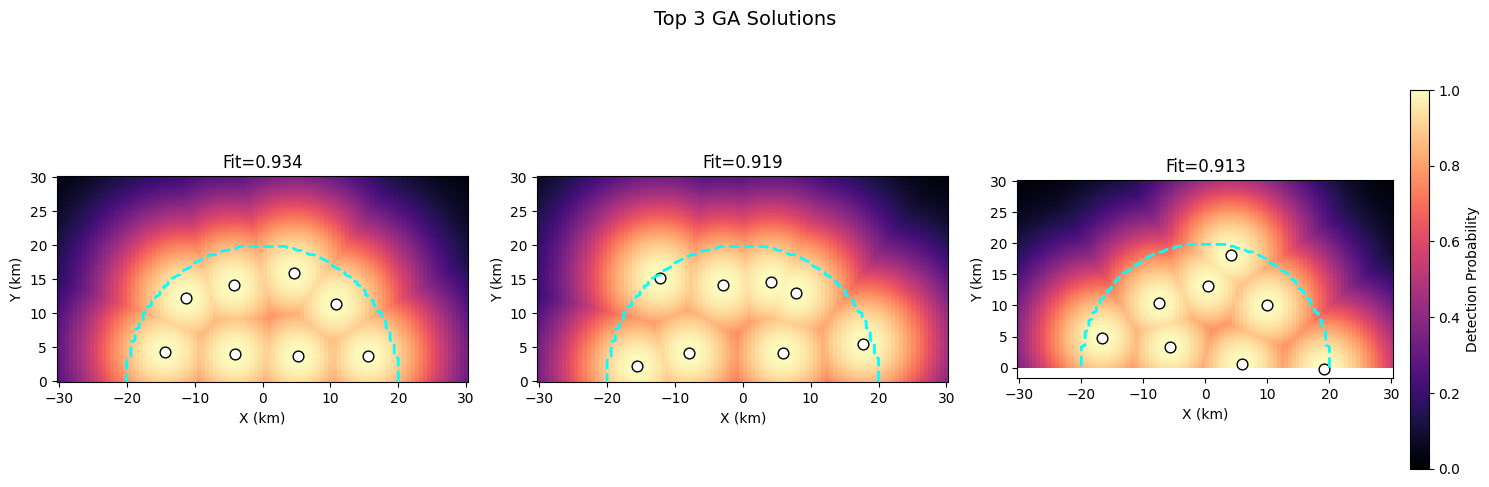


Example 2: Custom star polygon mask
Gen 01 | Mean=0.1494 | Best=0.5419 | Stag=0
Gen 02 | Mean=0.4047 | Best=0.5670 | Stag=0
Gen 03 | Mean=0.5431 | Best=0.6233 | Stag=0
Gen 04 | Mean=0.5919 | Best=0.6413 | Stag=0
Gen 05 | Mean=0.6001 | Best=0.6673 | Stag=0
Gen 06 | Mean=0.6210 | Best=0.6712 | Stag=0
Gen 07 | Mean=0.6491 | Best=0.6919 | Stag=0
Gen 08 | Mean=0.6714 | Best=0.7068 | Stag=0
Gen 09 | Mean=0.6772 | Best=0.7545 | Stag=0
Gen 10 | Mean=0.6857 | Best=0.7728 | Stag=0
Gen 11 | Mean=0.6980 | Best=0.7748 | Stag=0
Gen 12 | Mean=0.6257 | Best=0.7748 | Stag=1
Gen 13 | Mean=0.6685 | Best=0.7834 | Stag=0
Gen 14 | Mean=0.7012 | Best=0.7834 | Stag=1
Gen 15 | Mean=0.6981 | Best=0.7834 | Stag=2
Gen 16 | Mean=0.7168 | Best=0.7865 | Stag=0
Gen 17 | Mean=0.7413 | Best=0.7890 | Stag=0
Gen 18 | Mean=0.6936 | Best=0.7945 | Stag=0
Gen 19 | Mean=0.6968 | Best=0.7945 | Stag=1
Gen 20 | Mean=0.6694 | Best=0.7945 | Stag=2
Gen 21 | Mean=0.7433 | Best=0.7950 | Stag=0
Gen 22 | Mean=0.6461 | Best=0.7962 | St

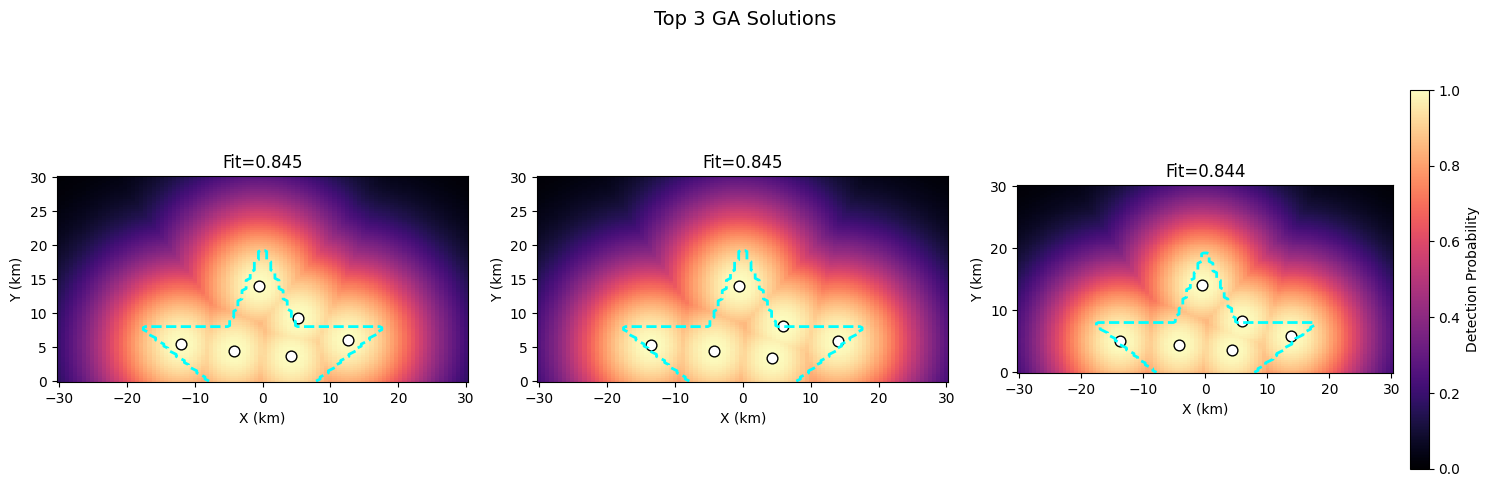


Example 3: Rectangle mask
Gen 01 | Mean=0.4928 | Best=0.7915 | Stag=0
Gen 02 | Mean=0.7546 | Best=0.8028 | Stag=0
Gen 03 | Mean=0.7563 | Best=0.8028 | Stag=1
Gen 04 | Mean=0.8006 | Best=0.8136 | Stag=0
Gen 05 | Mean=0.8113 | Best=0.8279 | Stag=0
Gen 06 | Mean=0.8221 | Best=0.8330 | Stag=0
Gen 07 | Mean=0.8244 | Best=0.8417 | Stag=0
Gen 08 | Mean=0.8366 | Best=0.8487 | Stag=0
Gen 09 | Mean=0.8394 | Best=0.8542 | Stag=0
Gen 10 | Mean=0.8507 | Best=0.8574 | Stag=0
Gen 11 | Mean=0.8555 | Best=0.8635 | Stag=0
Gen 12 | Mean=0.8379 | Best=0.8672 | Stag=0
Gen 13 | Mean=0.8598 | Best=0.8713 | Stag=0
Gen 14 | Mean=0.8689 | Best=0.8805 | Stag=0
Gen 15 | Mean=0.8674 | Best=0.8833 | Stag=0
Gen 16 | Mean=0.8479 | Best=0.8833 | Stag=1
Gen 17 | Mean=0.8705 | Best=0.8877 | Stag=0
Gen 18 | Mean=0.8774 | Best=0.8891 | Stag=0
Gen 19 | Mean=0.8833 | Best=0.8941 | Stag=0
Gen 20 | Mean=0.8866 | Best=0.8966 | Stag=0
Gen 21 | Mean=0.8914 | Best=0.8974 | Stag=0
Gen 22 | Mean=0.8951 | Best=0.8995 | Stag=0
Gen 2

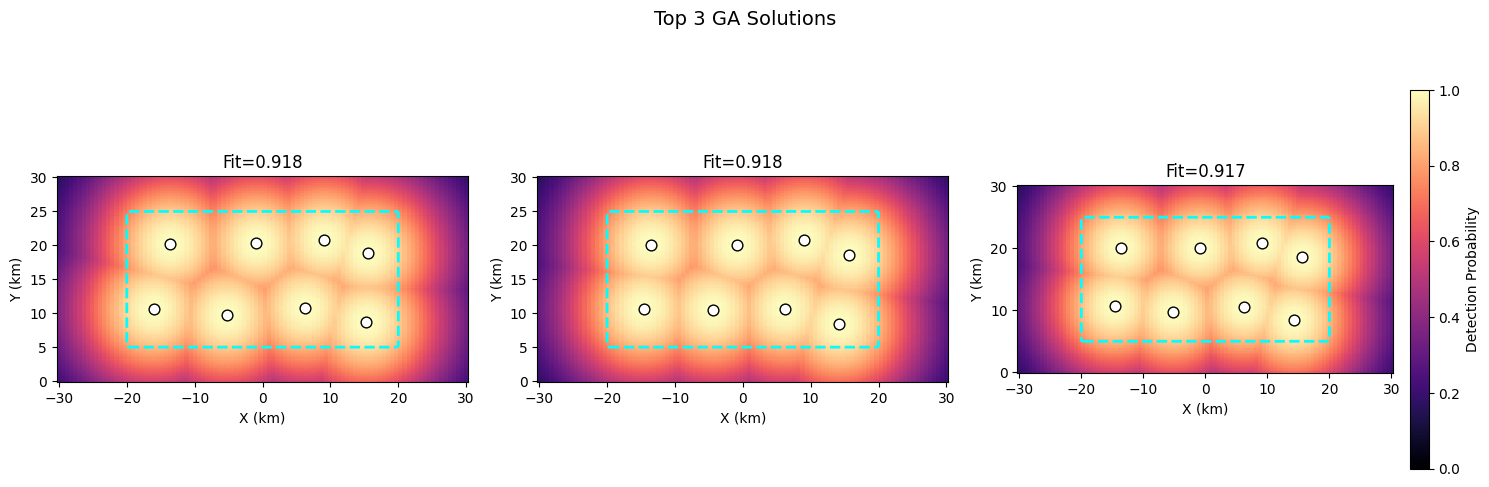

In [ ]:
if __name__ == "__main__":
    # Grid definition
    xlim, ylim = (-30, 30), (0, 30)
    grid_x = np.linspace(*xlim, 100)
    grid_y = np.linspace(*ylim, 100)

    # Detection function
    sd = 10.0
    det_func = lambda d: half_normal(d, sd)

    # Example 1: Semicircle mask
    print("=" * 60)
    print("Example 1: Semicircle mask")
    print("=" * 60)
    mask_semicircle = semicircle_mask(grid_x, grid_y, radius=20.0)
    env1 = Environment(grid_x, grid_y, det_func, mask_semicircle,
                       generations=50, num_recorders=8, metric='mean',
                       empty_penalty_fraction=1, mutation_rate=0.5)
    best1, scores1 = env1.run(k_top=3)

    # Example 2: Custom polygon mask (star shape)
    print("\n" + "=" * 60)
    print("Example 2: Custom star polygon mask")
    print("=" * 60)
    star_vertices = [
        (0, 20), (5, 8), (18, 8), (8, 0), (12, -12),
        (0, -5), (-12, -12), (-8, 0), (-18, 8), (-5, 8)
    ]
    mask_star = create_custom_shape_mask(grid_x, grid_y, star_vertices)
    env2 = Environment(grid_x, grid_y, det_func, mask_star,
                       generations=50, num_recorders=6, metric='maxmin',
                       mutation_rate=0.3)
    best2, scores2 = env2.run(k_top=3)

    # Example 3: Rectangle mask
    print("\n" + "=" * 60)
    print("Example 3: Rectangle mask")
    print("=" * 60)
    mask_rect = rectangle_mask(grid_x, grid_y, -20, 20, 5, 25)
    env3 = Environment(grid_x, grid_y, det_func, mask_rect,
                       generations=50, num_recorders=8, metric='mean')
    best3, scores3 = env3.run(k_top=3)



Gen 01 | Mean=0.5126 | Best=0.6880 | Stag=0
Gen 02 | Mean=0.6374 | Best=0.7181 | Stag=0
Gen 03 | Mean=0.6987 | Best=0.7278 | Stag=0
Gen 04 | Mean=0.7191 | Best=0.7278 | Stag=1
Gen 05 | Mean=0.7225 | Best=0.7361 | Stag=0
Gen 06 | Mean=0.7266 | Best=0.7377 | Stag=0
Gen 07 | Mean=0.7060 | Best=0.7432 | Stag=0
Gen 08 | Mean=0.7317 | Best=0.7608 | Stag=0
Gen 09 | Mean=0.7539 | Best=0.7635 | Stag=0
Gen 10 | Mean=0.7633 | Best=0.7731 | Stag=0
Gen 11 | Mean=0.7562 | Best=0.7792 | Stag=0
Gen 12 | Mean=0.7620 | Best=0.7792 | Stag=1
Gen 13 | Mean=0.7718 | Best=0.7845 | Stag=0
Gen 14 | Mean=0.7783 | Best=0.7855 | Stag=0
Gen 15 | Mean=0.7643 | Best=0.7965 | Stag=0
Gen 16 | Mean=0.7810 | Best=0.7965 | Stag=1
Gen 17 | Mean=0.7850 | Best=0.7970 | Stag=0
Gen 18 | Mean=0.7846 | Best=0.7985 | Stag=0
Gen 19 | Mean=0.7773 | Best=0.7985 | Stag=1
Gen 20 | Mean=0.7567 | Best=0.7986 | Stag=0
Gen 21 | Mean=0.7710 | Best=0.8002 | Stag=0
Gen 22 | Mean=0.7969 | Best=0.8007 | Stag=0
Gen 23 | Mean=0.7993 | Best=0.80

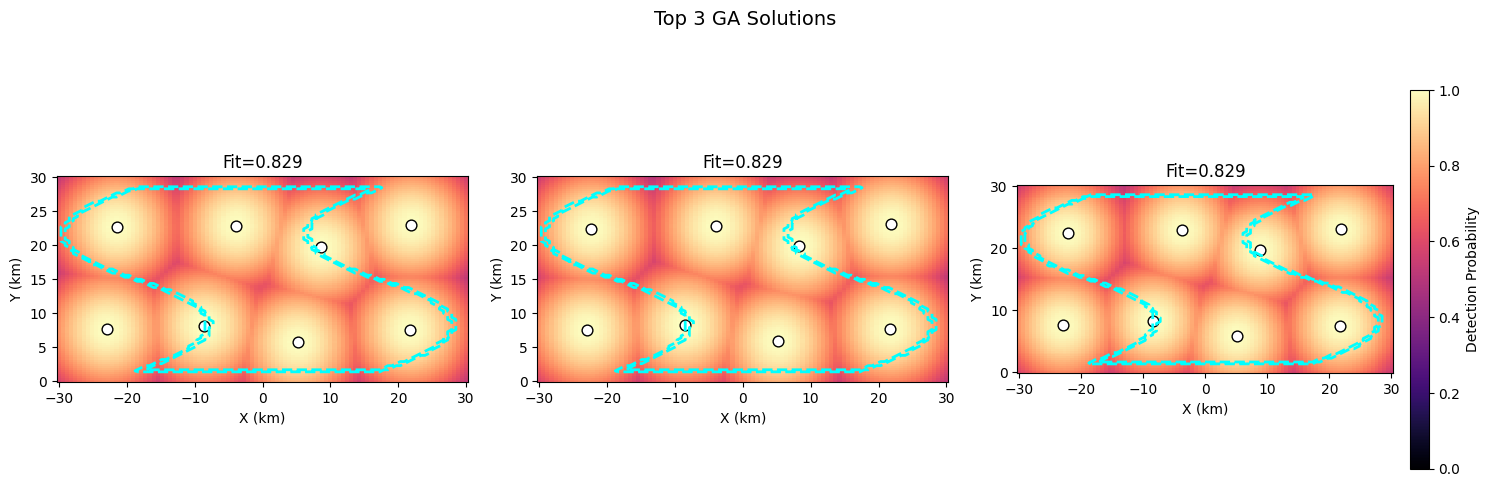

In [ ]:
    mask_from_image = load_mask_from_image('mask.png', grid_x, grid_y)
    env4 = Environment(grid_x, grid_y, det_func, mask_from_image)
    best4, scores4 = env4.run(k_top=3)